In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import pickle
import re
import spacy
import nltk
from nltk.corpus import wordnet, stopwords
import random
import xgboost as xgb
import emoji
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

check data Missing Values

In [2]:
nlp = spacy.load("en_core_web_sm")

fill the missing value with empty string

In [3]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/rebecca/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/rebecca/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
# Path ke file Excel
file_path = 'data/origin-data/genshin_impact_reviews.csv'

# Membaca dataset dari Excel
data = pd.read_csv(file_path)

data.head()

,id,title,avatar,rating,snippet,likes,date,iso_date,response
0,45b29182-3368-445f-8353-efc25383ea9f,Francesca Ashley Inguito,NaN,1,"This was awful, the dialogue of characters in ...",1,2025-01-12 17:37:21,2025-01-12T17:37:21,NaN
1,5baab1b9-0540-4ac3-90c9-1ee3462bdc73,Ikmal Hariz,NaN,5,MANYAK BAGUS LA I LIKE CUMA PLS CEPAT KAN SIKI...,0,2025-01-12 02:42:05,2025-01-12T02:42:05,NaN
2,4de306eb-b9aa-4b44-a1f9-fb7adbde027a,Luna,NaN,5,Good,1,2025-01-10 20:11:24,2025-01-10T20:11:24,NaN
3,27a1f807-e2d0-4fd5-9d83-5f3f6f5b0a45,Mohamad Indra N.,NaN,1,The lack of a skip button is one of my main re...,126,2025-01-09 03:59:54,2025-01-09T03:59:54,Thank you for your constant support of Genshin...
4,b2360ca2-fe1a-47f9-a895-cd5b362a49c3,Elizer Vaxter,NaN,1,I like capitano. I'm a male. I'm not gay. See ...,35,2025-01-05 07:29:37,2025-01-05T07:29:37,NaN


In [5]:
# Menghapus kolom yang tidak diperlukan
data = data.drop(columns=['id', 'avatar', 'date', 'iso_date', 'response', 'likes'])

# Menyimpan file yang sudah diproses ke dalam folder 'data/preprocessed/'
preprocessed_file_path = 'data/preprocessed/genshin_impact_reviews_processed.csv'
data.to_csv(preprocessed_file_path, index=False)

# Menampilkan data yang telah diproses
data.head()

,title,rating,snippet
0,Francesca Ashley Inguito,1,"This was awful, the dialogue of characters in ..."
1,Ikmal Hariz,5,MANYAK BAGUS LA I LIKE CUMA PLS CEPAT KAN SIKI...
2,Luna,5,Good
3,Mohamad Indra N.,1,The lack of a skip button is one of my main re...
4,Elizer Vaxter,1,I like capitano. I'm a male. I'm not gay. See ...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    1000 non-null   object
 1   rating   1000 non-null   int64 
 2   snippet  1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


In [7]:
hate_keywords = [
    'achievement', 'add', 'android', 'bug', 'button', 'character', 'controller', 'datum', 'dialogue', 
    'dumb', 'end', 'fix', 'game', 'geo', 'good', 'level', 'like', 'low', 'old', 'platform', 'play', 'quest', 
    'realmi', 'release', 'skip', 'star', 'story', 'time', 'update', 'wait', 'world', 'year', 'bug', 'dumb', 
    'stupid', 'lag', 'crash', 'glitch', 'unplayable', 'boring', 'disappointed', 'unresponsive', 'failure', 
    'worse', 'terrible', 'awful', 'frustrating', 'hate', 'garbage', 'trash', 'worst', 'annoying', 'broken', 
    'complain', 'refund', 'scam', 'hate', 'problem', 'sucks', 'crappy', 'uninstall', 'boring', 'slow', 
    'disappointing', 'messy', 'useless', 'terrible', 'poor'
]

# Fungsi untuk membersihkan teks
def clean_text(text):
    """
    Fungsi untuk membersihkan teks: mengubah menjadi lowercase, menghapus angka, simbol, karakter khusus, emoji,
    serta melakukan lemmatization dan menghapus stop words.
    """
    # Mengubah teks menjadi huruf kecil
    text = text.lower()
    
    # Menghapus emoji menggunakan emoji library
    text = emoji.replace_emoji(text, replace='')

    # Menggunakan spaCy untuk memproses teks
    doc = nlp(text)

    # Lemmatization dan Stopword Removal menggunakan spaCy
    text = ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

    # Menghapus multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Fungsi untuk augmentasi teks dengan mengganti kata dengan sinonim
def augment_text(text):
    """
    Augmentasi teks dengan mengganti kata dengan sinonimnya menggunakan WordNet.
    """
    # Tokenize teks menggunakan spaCy
    doc = nlp(text)
    
    augmented_text = text
    for token in doc:
        # Ambil sinonim dari WordNet untuk setiap kata
        if token.pos_ in ['NOUN', 'VERB', 'ADJ', 'ADV']:  # Hanya untuk kata benda, kata kerja, adjektiva, dan adverbia
            synonyms = set()
            for syn in wordnet.synsets(token.text):
                for lemma in syn.lemmas():
                    synonyms.add(lemma.name())
            if len(synonyms) > 0:
                synonym = random.choice(list(synonyms))  # Pilih sinonim secara acak
                augmented_text = augmented_text.replace(token.text, synonym, 1)  # Ganti hanya satu kali
    
    return augmented_text

# Fungsi untuk mendeteksi jenis komentar tanpa menggunakan hate_keywords
def detect_comment_type(row):
    """
    Mengategorikan komentar berdasarkan rating tanpa keberadaan kata kunci hate speech.
    """
    text = row['snippet']
    rating = row['rating']

    # Bersihkan teks sebelum analisis
    text = clean_text(text)

    # Augmentasi teks
    augmented_text = augment_text(text)

    # Jika rating berada di antara 3-5, maka komentar adalah Positif
    if rating >= 3:
        return 1

    # Jika rating berada di antara 1-2, maka komentar dianggap negatif (non-hate speech).
    if rating <= 2:
        if any(hate_word in augmented_text for hate_word in hate_keywords):  # Deteksi kata kunci kebencian
            return 0
        return 0  # Default jika tidak ada kata kunci kebencian

    return 0  # Default jika tidak memenuhi kondisi di atas

# Membaca dataset
preprocessed_file_path = 'data/preprocessed/genshin_impact_reviews_processed.csv'
data = pd.read_csv(preprocessed_file_path)

# Hapus nilai kosong di kolom 'snippet' dan 'title'
data = data.dropna(subset=['snippet', 'title'])

# Mengisi nilai kosong pada kolom 'snippet' dengan string kosong
data['snippet'] = data['snippet'].fillna('')

# Ubah teks pada kolom 'snippet' menjadi huruf kecil
data['snippet'] = data['snippet'].str.lower()

# Terapkan fungsi clean_text ke kolom 'snippet' untuk membersihkan teks
data['snippet'] = data['snippet'].apply(clean_text)

# Terapkan fungsi untuk mendeteksi dan melabeli komentar
data['label'] = data.apply(detect_comment_type, axis=1)

# Menyimpan file yang sudah diproses ke dalam folder 'data/preprocessed/'
final_file_path = 'data/preprocessed/preprocessed_Genshin.csv'
data.to_csv(final_file_path, index=False)

# Menampilkan dataset setelah pelabelan
print("\nDataset Setelah Pelabelan:")
print(data[['rating', 'snippet', 'label']].head(10))



Dataset Setelah Pelabelan:
   rating                                            snippet  label
0       1  awful dialogue character story long take lante...      0
1       5  manyak bagus la like cuma pls cepat kan sikit ...      1
2       5                                               good      1
3       1  lack skip button main reason quit convert wuwa...      0
4       1                             like capitano male gay      0
5       1                         play chromebook irritating      0
6       1                                           suck rng      0
7       1                        money you capitano playable      0
8       1  basically sum game waste time tricksteri hoyov...      0
9       1                                        игра параша      0


In [8]:
# Membagi Data menjadi Fitur dan Label
X = data['snippet']  # Menggunakan snippet dan rating sebagai fitur
y = data['label']  # Label klasifikasi

# Membagi Data menjadi Training dan Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nJumlah Data Training:", len(X_train))
print("Jumlah Data Testing:", len(X_test))


Jumlah Data Training: 800
Jumlah Data Testing: 200


In [9]:
# Ekstraksi Fitur dengan TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Maksimal fitur 5000 untuk efisiensi
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
print("\nShape Data TF-IDF (Training):", X_train_tfidf.shape)


Shape Data TF-IDF (Training): (800, 2117)


In [10]:
y_train.value_counts()

label
1    594
0    206
Name: count, dtype: int64

In [11]:
# SMOTE untuk oversampling kelas minoritas
smote = SMOTE(random_state=42)

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

fold = 1
accuracy_scores = []

for train_index, test_index in kf.split(X_train_tfidf, y_train):
    print(f"\nFold {fold}")

    # Splitting the data
    X_train_fold, X_test_fold = X_train_tfidf[train_index], X_train_tfidf[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Applying SMOTE on training data
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)

    # Model training - Mengganti dengan XGBClassifier
    model = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train_resampled, y_train_resampled)

    # Predictions
    y_pred = model.predict(X_test_fold)

    # Evaluating the model
    acc = accuracy_score(y_test_fold, y_pred)
    accuracy_scores.append(acc)
    print(classification_report(y_test_fold, y_pred))

    fold += 1

# Display average accuracy across all folds
print("\nAverage Accuracy:", np.mean(accuracy_scores))



Fold 1


/home/rebecca/Campus/System-Retrieval-Information/xx/system-retrieval-information/GI/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [06:25:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.65      0.55      0.59        20
           1       0.86      0.90      0.88        60

    accuracy                           0.81        80
   macro avg       0.75      0.73      0.74        80
weighted avg       0.80      0.81      0.81        80


Fold 2


/home/rebecca/Campus/System-Retrieval-Information/xx/system-retrieval-information/GI/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [06:25:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.58      0.35      0.44        20
           1       0.81      0.92      0.86        60

    accuracy                           0.78        80
   macro avg       0.70      0.63      0.65        80
weighted avg       0.75      0.78      0.75        80


Fold 3


/home/rebecca/Campus/System-Retrieval-Information/xx/system-retrieval-information/GI/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [06:25:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.77      0.50      0.61        20
           1       0.85      0.95      0.90        60

    accuracy                           0.84        80
   macro avg       0.81      0.72      0.75        80
weighted avg       0.83      0.84      0.82        80


Fold 4


/home/rebecca/Campus/System-Retrieval-Information/xx/system-retrieval-information/GI/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [06:25:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.60      0.60      0.60        20
           1       0.87      0.87      0.87        60

    accuracy                           0.80        80
   macro avg       0.73      0.73      0.73        80
weighted avg       0.80      0.80      0.80        80


Fold 5


/home/rebecca/Campus/System-Retrieval-Information/xx/system-retrieval-information/GI/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [06:25:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.65      0.52      0.58        21
           1       0.84      0.90      0.87        59

    accuracy                           0.80        80
   macro avg       0.74      0.71      0.72        80
weighted avg       0.79      0.80      0.79        80


Fold 6


/home/rebecca/Campus/System-Retrieval-Information/xx/system-retrieval-information/GI/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [06:25:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.64      0.67      0.65        21
           1       0.88      0.86      0.87        59

    accuracy                           0.81        80
   macro avg       0.76      0.77      0.76        80
weighted avg       0.82      0.81      0.81        80


Fold 7


/home/rebecca/Campus/System-Retrieval-Information/xx/system-retrieval-information/GI/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [06:25:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.52      0.52      0.52        21
           1       0.83      0.83      0.83        59

    accuracy                           0.75        80
   macro avg       0.68      0.68      0.68        80
weighted avg       0.75      0.75      0.75        80


Fold 8


/home/rebecca/Campus/System-Retrieval-Information/xx/system-retrieval-information/GI/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [06:25:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.71      0.57      0.63        21
           1       0.86      0.92      0.89        59

    accuracy                           0.82        80
   macro avg       0.78      0.74      0.76        80
weighted avg       0.82      0.82      0.82        80


Fold 9


/home/rebecca/Campus/System-Retrieval-Information/xx/system-retrieval-information/GI/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [06:25:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.55      0.52      0.54        21
           1       0.83      0.85      0.84        59

    accuracy                           0.76        80
   macro avg       0.69      0.69      0.69        80
weighted avg       0.76      0.76      0.76        80


Fold 10


/home/rebecca/Campus/System-Retrieval-Information/xx/system-retrieval-information/GI/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [06:25:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.76      0.62      0.68        21
           1       0.87      0.93      0.90        59

    accuracy                           0.85        80
   macro avg       0.82      0.78      0.79        80
weighted avg       0.84      0.85      0.84        80


Average Accuracy: 0.8025


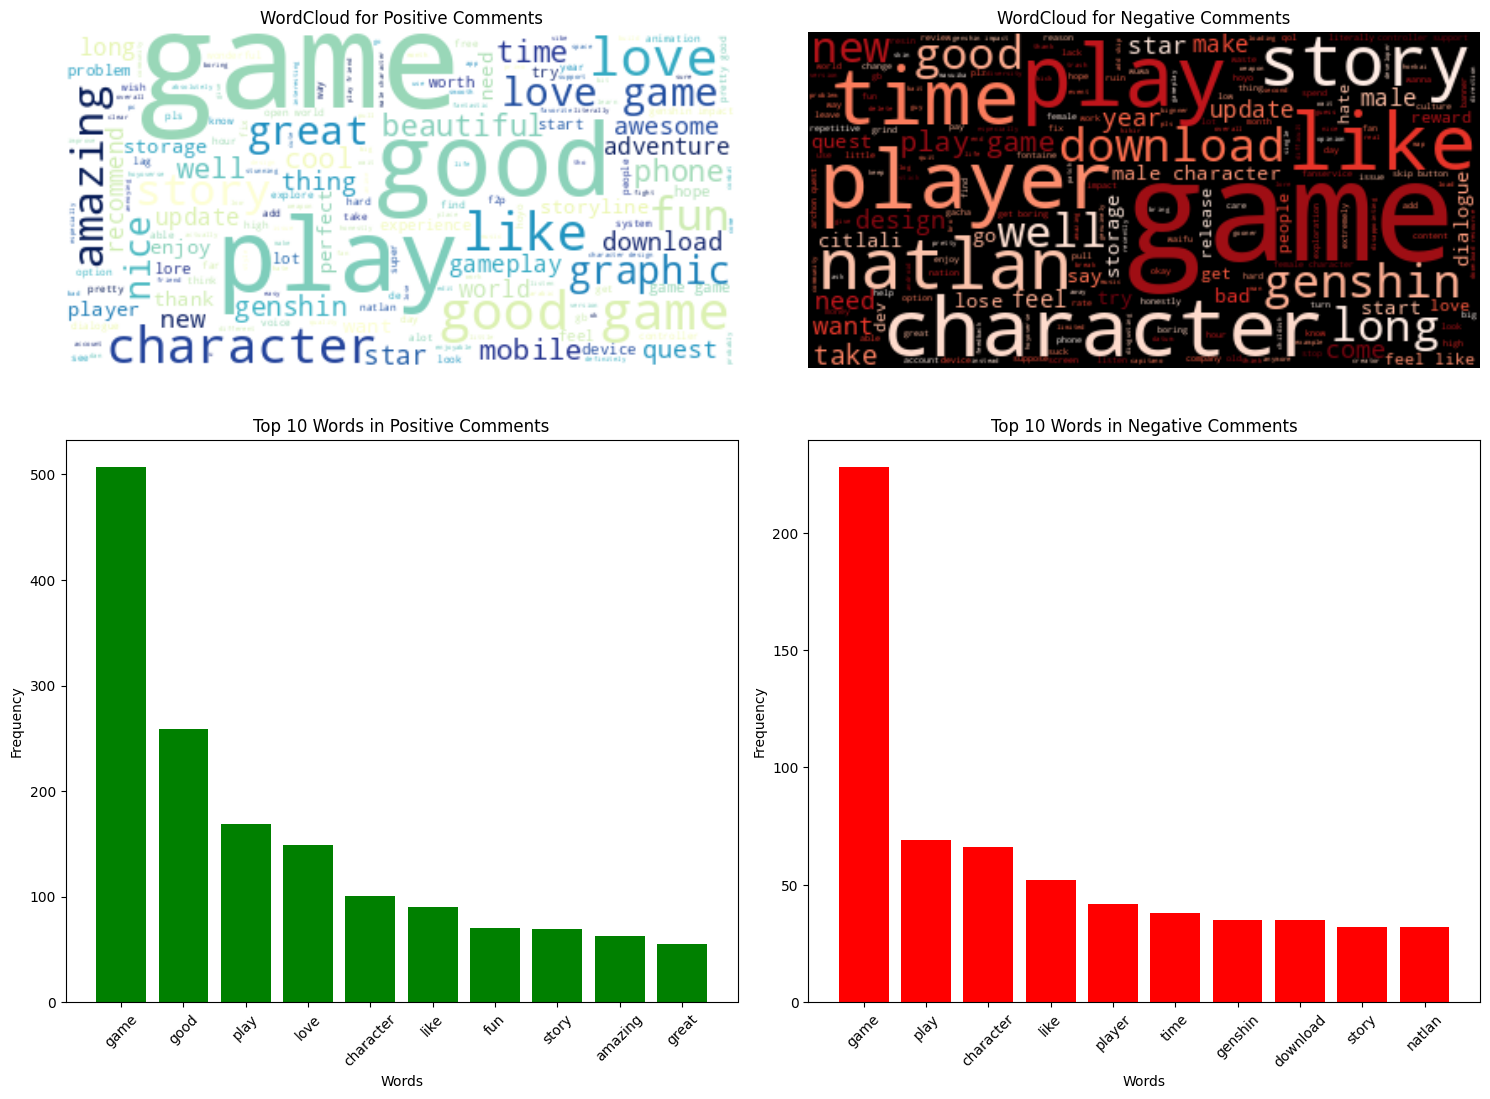

In [12]:
# Membaca dataset yang sudah dilabeli
data = pd.read_csv('data/preprocessed/preprocessed_Genshin.csv')

# Memastikan teks bersih dari nilai null
data = data.dropna(subset=['snippet'])

# Menyaring teks positif dan negatif
positive_text = data[data['label'] == 1]['snippet']
negative_text = data[data['label'] == 0]['snippet']

# Gabungkan semua teks positif dan negatif menjadi satu string
positive_text = ' '.join(positive_text)
negative_text = ' '.join(negative_text)

# Fungsi untuk menampilkan WordCloud dengan warna yang berbeda untuk komentar negatif
def generate_wordcloud(text, ax, title, color='black', background='white'):
    wordcloud = WordCloud(width=400, height=200, background_color=background, stopwords=stopwords.words('english'),
                          colormap=color).generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(title)

# Menghitung kata terbanyak pada komentar positif dan negatif
positive_words = ' '.join(positive_text.split())
negative_words = ' '.join(negative_text.split())

positive_word_count = Counter(positive_words.split())
negative_word_count = Counter(negative_words.split())

# Mengambil 10 kata terbanyak
positive_top_words = dict(positive_word_count.most_common(10))
negative_top_words = dict(negative_word_count.most_common(10))

# Membuat subplot untuk WordCloud dan Bar Plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Visualisasi WordCloud untuk komentar positif dengan warna cerah
generate_wordcloud(positive_text, axes[0, 0], 'WordCloud for Positive Comments', color='YlGnBu')

# Visualisasi WordCloud untuk komentar negatif dengan latar belakang hitam dan colormap 'Reds'
generate_wordcloud(negative_text, axes[0, 1], 'WordCloud for Negative Comments', color='Reds', background='black')

# Bar Plot untuk kata terbanyak pada komentar positif
axes[1, 0].bar(positive_top_words.keys(), positive_top_words.values(), color='green')
axes[1, 0].set_title("Top 10 Words in Positive Comments")
axes[1, 0].set_xlabel("Words")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].tick_params(axis='x', rotation=45)

# Bar Plot untuk kata terbanyak pada komentar negatif dengan warna merah
axes[1, 1].bar(negative_top_words.keys(), negative_top_words.values(), color='red')
axes[1, 1].set_title("Top 10 Words in Negative Comments")
axes[1, 1].set_xlabel("Words")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [13]:
# Menyimpan model yang sudah dilatih ke dalam file .pkl
with open('xgb_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)
    print("Model telah disimpan dalam file 'xgb_model.pkl'.")

# Menyimpan vectorizer yang sudah dilatih ke dalam file .pkl
with open('vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)
    print("Vectorizer telah disimpan dalam file 'vectorizer.pkl'.")

Model telah disimpan dalam file 'xgb_model.pkl'.
Vectorizer telah disimpan dalam file 'vectorizer.pkl'.
